In [1]:
import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# DECODE - Training

This notebook highlights how to train a DECODE model for fitting experimental data.

The DECODE network is trained on simulated data. This requires a calibration spline based PSF model,
and a parameter file that contains camera settings and other hyper parameters to set up the simulation process.

While we provide an example calibration file here to demonstrate the training procedure you will have to create one yourself for your own data.

## Set parameters
Set device for training. We **do not recommend training on CPU** since this will be quite slow. If you train on CPU though, you may want to change the number of threads if you have a big machine (see below).

In [2]:
device = 'cuda:0'  # or 'cpu', or you change cuda device index
threads = 4  #  number of threads, useful for CPU heavy computation. Change if you know what you are doing.
worker = 4  # number of workers for data loading. Change only if you know what you are doing.

torch.set_num_threads(threads)  # set num threads

In [3]:
# load example calibration file from server (this can be skipped)
gateway = decode.utils.example_helper.load_gateway()

# dir where to store example data, leave as '' to store in current folder
path = Path('')

# change here for other files
package = gateway['examples']['package_1']

# get paths to files
zip_folder = decode.utils.example_helper.load_example_package(
    path=(path / package['name']).with_suffix('.zip'), url=package['url'], hash=package['hash'])

calib_file = str(zip_folder / 'spline_calibration_3dcal.mat')

Found file already in Cache.


## Bead calibration

To obtain the calibration file a spline model is fit on a stack of beads.     
We recommend to use fit3Dspline which is part of the SMAP package.

1. Install the stand-alone version of SMAP from [www.rieslab.de](www.rieslab.de) or if you have Matlab, downlowd the source-code from [www.github.com/jries/SMAP](www.github.com/jries/SMAP). There, you also find the installation instructions and Documentation.
2. Acquire z-stacks with fluorescent beads (e.g. 100 nm beads). We typcally use a z-range of +/- 750 nm and a step size of 10-50 nm.
3. In SMAP, use the plugin *calibrate3DSplinePSF* to generate the calibartion file. In the user guide (accessible from the SMAP help menu) in section 5.4, this is explained in detail. Further information about the calibration process can be found in [Li et al, Nature Methods (2018)](https://doi.org/10.1038/nmeth.4661).

In [4]:
# uncomment and exectue only if you have not executed the example download cell above
# calib_file = 'examples/2020-07-23_Pos0_beads_Z_1_MMStack_Default.ome_3dcal.mat'

## Simulation Parameters

To set the simulation parameters we load the default config file and go through the settings

In [5]:
# copy default parameter files which are then changed as specified
decode.utils.param_io.copy_reference_param('')  # saved in current dir

In [6]:
param = decode.utils.param_io.load_params('param_friendly.yaml')

param.Hardware.device = device
param.Hardware.device_simulation = device
param.Hardware.torch_threads = threads
param.Hardware.num_worker_train = worker

The camera parameters need to be adjusted according to the device used. Here we used an EMCCD camera, for a sCMOS device you must set the em_gain to None.

In [7]:
param.Camera.baseline = 398.6
param.Camera.e_per_adu = 5.0
param.Camera.em_gain = 100
param.Camera.px_size =[127.0, 117.0] # Pixel Size in nano meter
param.Camera.qe = 1.0                # Quantum efficiency
param.Camera.read_sigma = 58.8
param.Camera.spur_noise = 0.0015

param.Camera.to_dict()

{'baseline': 398.6,
 'convert2photons': True,
 'e_per_adu': 5.0,
 'em_gain': 100,
 'px_size': [127.0, 117.0],
 'qe': 1.0,
 'read_sigma': 58.8,
 'spur_noise': 0.0015}

The simulation parameters should be set so that the resulting simulated frames resemble real frames as closely as possible.
You can use SMAP to infer these parameters by performing inference with an iterative approach on a couple of frames:

1. Use the bead calibration to fit your SMLM data.
2. Use the plugin: *DECODE\_training\_estimates* to estimate the photo-physical parameters of the experiment and to save them into a parameter file. Consult the information of the plugin (accessible via the Info button) for further information.

However it is also possible to find reasonable values by hand which we do now.

In [8]:
param.Simulation.bg_uniform = [20.0, 100.0]           # background range to sample from. You can also specify a const. value as 'bg_uniform = 100'
param.Simulation.emitter_av = 20                      # Average number of emitters per frame
param.Simulation.emitter_extent[2] = [-800, 800]    # Volume in which emitters are sampled. x,y values should not be changed. z-range (in nm) should be adjusted according to the PSF
param.Simulation.intensity_mu_sig = [7000.0, 3000.0]  # Average intensity and its standard deviation
param.Simulation.lifetime_avg = 2                     # Average lifetime of each emitter in frames. 2 works for most experiments

param.Simulation.to_dict()

{'bg_uniform': [20.0, 100.0],
 'density': None,
 'emitter_av': 20,
 'emitter_extent': [[-0.5, 39.5], [-0.5, 39.5], [-800, 800]],
 'img_size': [40, 40],
 'intensity_mu_sig': [7000.0, 3000.0],
 'intensity_th': None,
 'lifetime_avg': 2,
 'mode': 'acquisition',
 'photon_range': None,
 'psf_extent': [[-0.5, 39.5], [-0.5, 39.5], None],
 'roi_size': None,
 'roi_auto_center': False,
 'xy_unit': 'px'}

Lastly we provide the path to the calibration file, and to the output destination.
There are more parameters (you can just execute param in a cell to look at them) that you should not need to change.   
You might have to reduce the batch size (param.HyperParameter.batch_size) if you run out of memory.

In [9]:
param.InOut.calibration_file = calib_file
param.InOut.experiment_out = ''

param.InOut.to_dict()

{'calibration_file': 'package_1/spline_calibration_3dcal.mat',
 'experiment_out': '',
 'model_init': None}

Now we can set up our simulator and the camera model.

In [10]:
simulator, sim_test = decode.neuralfitter.train.live_engine.setup_random_simulation(param)
camera = decode.simulation.camera.Photon2Camera.parse(param)

In [11]:
# finally we derive some parameters automatically for easy use
param = decode.utils.param_io.autoset_scaling(param)

Let us sample a set frames, and also load our data: 

In [12]:
tar_em, sim_frames, bg_frames = simulator.sample()
sim_frames = sim_frames.cpu()

data_frames = decode.utils.frames_io.load_tif('package_1/frames.tif').cpu()

print(f'Data shapes, simulation: {sim_frames.shape}, real data: {data_frames.shape}')
print(f'Average value, simulation: {sim_frames.mean().round()}, real data: {data_frames.mean().round()}')

Data shapes, simulation: torch.Size([10001, 40, 40]), real data: torch.Size([20000, 180, 179])
Average value, simulation: 109.0, real data: 1599.0


Looking at the mean brightness, we see that there is a large missmatch. The reason is that we simulate the photons that are emitted by the fluorophores, while the tiff file shows the photons that are recorded by the camera (after amplificiation). To enable direct comparison we convert the real data frames into photon numbers.   
Be aware that camera.forward()  and camera.forward() are not each others inverse. forward() performs noise sampling, while backward() simply rescales by the em_gain

In [13]:
data_frames = camera.backward(data_frames, device='cpu')
print(f'Average value, simulation: {sim_frames.mean().round()}, real data: {data_frames.mean().round()}')

Average value, simulation: 109.0, real data: 60.0


By comparing random frames (chosing a dense region of the real data) we can convince ourselves that the distributions are somewhat similar.   
If you observe large differences for your dataset, you probably have to adjust param.Simulation.bg_uniform and param.Simulation.intensity_mu_sig

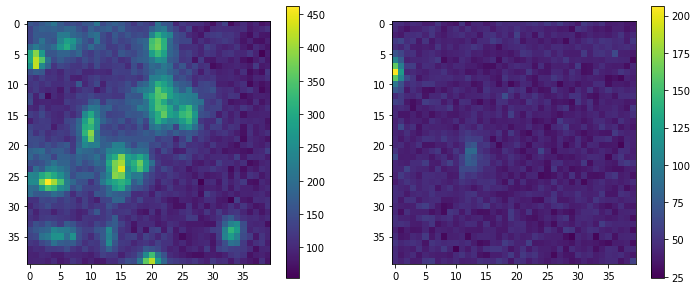

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(sim_frames[np.random.randint(0,len(sim_frames))])
plt.colorbar()
plt.subplot(122)
plt.imshow(data_frames[np.random.randint(0,len(data_frames)), 30:70,-40:])
plt.colorbar()

plt.show()

Once you are happy with you settings you can write the parameters to a file (or edit the param_friendly.yaml directly)

In [15]:
param_out_path = 'notebook_example.yaml' # or an alternative path
decode.utils.param_io.save_params(param_out_path, param)  

To start training execute the following cell or you can also start the training script in your terminal

    python -m decode.neuralfitter.train.live_engine -p notebook_example.yaml  # change path if you modified it

To check training progress you should start a tensorboard. Please navigate (within the terminal, in a new terminal window/tab) to the directory of this notebook and start tensorboard. Don't forget to activate the conda environment before starting tensorboard.

    cd [directory which containts 'runs', i.e. this notebook's path]
    conda activate decode_env
    tensorboard --samples_per_plugin images=100 --port=6006 --logdir=runs

And open it in your browser: http://localhost:6006
Numereous evaluation metrics are tracked here. Under the 'Images' header you can see example frames and localizations.   
Keep in mind though that these are all calculated on the simulated data. So you can check whether the training has converged, 
but you'll have to run the model on the actual data to see if you set the parameters correctly.

For that open the Fit.ipynb notebook.

In [ ]:
# run from here or from terminal as specified above
decode.neuralfitter.train.live_engine.live_engine_setup(param_file=param_out_path)